In [0]:
!kaggle competitions download -c stayalert

In [0]:
from google.colab import files

In [0]:
# Data import
train = pd.read_csv('fordTrain.csv')
test = pd.read_csv('fordTest.csv')
sol = pd.read_csv('Solution.csv')
exp = pd.read_csv('example_submission.csv')

In [0]:
# Library Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.svm import LinearSVC # Linear Support Vector Classigication
from sklearn.svm import NuSVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

In [18]:
len(train)

604329

In [0]:
# =============================================================================
# Data preprocessing
# =============================================================================

new_df = pd.DataFrame()  # Subset

noalert = train.index[train['IsAlert'] == 0]
turnnoalert = train.iloc[noalert-1][train['IsAlert'] == 1] # The change moment data


#new_df 

for i in turnnoalert.index: # Return 500ms before and after the moment
    new_df = new_df.append(train[i-5:i+6])
    
new_df = new_df.drop_duplicates() # Drop Dupicate instances

#new_df
sum(new_df.isna())

In [0]:
pcadata = new_df.drop(columns = ['TrialID', 'ObsNum', 'IsAlert']) # Drop unneccessary columns

# Standarization

X_scaled = preprocessing.scale(pcadata) 
pcadata.info()

# Principle Component Analysis



In [0]:
pcadata.info()

In [0]:
pca=PCA() 
pca.fit(X_scaled) 


In [0]:
X_pca=pca.transform(X_scaled) 
#let's check the shape of X_pca array
print ("shape of X_pca", X_pca.shape)
#%%
# Scree Plot
y = pca.explained_variance_ratio_

x = np.array([i for i in range(1, len(y)+1)])

plt.plot(x, y, 'r-x')

In [0]:
# Filter principle components
sum(pca.explained_variance_ratio_[:14])
X_pca = X_pca[:,:14] # Slice the first 14 features
X_pca.shape 

X_pca # Training features
new_df.IsAlert # Target features

In [0]:
skf = StratifiedKFold(n_splits=10)
params = {}
nb = GaussianNB()
gs = GridSearchCV(nb, cv=skf, param_grid=params, return_train_score=True)

x_train, x_test, y_train, y_test = train_test_split(X_pca, new_df.IsAlert, random_state = 42)


In [0]:

# Nu - SVC
nusvc = NuSVC(gamma = 'scale')
nusvcgridsearch = GridSearchCV(nusvc, cv = skf, param_grid = params, return_train_score = True)
nusvcgridsearch.fit(x_train, y_train) 



In [0]:
nusvcgridsearch.cv_results_


In [0]:
nusvcgridsearch.score(X_pca, new_df.IsAlert)

In [0]:
nusvc_predict = nusvcgridsearch.predict(X_pca)

confusion_matrix(new_df.IsAlert, nusvc_predict)

In [0]:

roc_auc_score(new_df.IsAlert, nusvc_predict)

In [0]:
from sklearn.svm import SVR
from sklearn.svm import SVC

In [0]:
# epsilon - SVR
svr = SVR(gamma='scale', C=1.0, epsilon=0.2)
svrgridsearch = GridSearchCV(svr, cv = skf, param_grid = params, return_train_score = True)
svrgridsearch.fit(x_train, y_train) 

In [0]:
svrgridsearch.cv_results_

In [0]:
svrgridsearch.score(X_pca, new_df.IsAlert)

In [0]:
svr_predict = svrgridsearch.predict(X_pca)

confusion_matrix(new_df.IsAlert, svr_predict)

In [0]:
roc_auc_score(new_df.IsAlert, svr_predict)

In [0]:
# C - SVC
svc = SVC(gamma='auto')
svcgridsearch = GridSearchCV(svc, cv = skf, param_grid = params, return_train_score = True)
svcgridsearch.fit(x_train, y_train) 

In [0]:
svcgridsearch.cv_results_

In [0]:
svcgridsearch.score(X_pca, new_df.IsAlert)

In [0]:
svc_predict = svcgridsearch.predict(X_pca)

confusion_matrix(new_df.IsAlert, svc_predict)

In [0]:
roc_auc_score(new_df.IsAlert, svc_predict)

In [0]:
from sklearn.neural_network import MLPClassifier

nn1 = MLPClassifier(solver='adam', alpha=1e-5,activation = 'logistic',hidden_layer_sizes=(14, 14, 12, 10, 5), random_state=1)
nngridsearch = GridSearchCV(nn1, cv = skf, param_grid = params, return_train_score = True)

In [0]:
nngridsearch.fit(x_train, y_train) 



In [0]:
nngridsearch.cv_results_


In [0]:
nngridsearch.score(X_pca, new_df.IsAlert)

In [0]:
nn_predict = nngridsearch.predict(X_pca)

confusion_matrix(new_df.IsAlert, nn_predict)

In [0]:
roc_auc_score(new_df.IsAlert, nn_predict)

# Model 2

# Use rolling means and std of each attribute as new features

In [19]:
#train_2 = train[train['TrialID'] <= 1]
train_new = pd.DataFrame() # New df
#train_new
for i in range(0, max(train.TrialID)+1): # Within each trial
    temp_data = train[train['TrialID'] == i] # Create a temporary df for each trial
    for j in list(train)[3:]: # For all the attributes of each trial
#        print (train_2[train_2['TrialID'] == i][j])
        temp_data['m{}'.format(j)] = train[train['TrialID'] == i][j].rolling(window = 5).mean() # Create the Rolling mean
        temp_data['sd{}'.format(j)] = train[train['TrialID'] == i][j].rolling(window = 5).std() # Create the Rolling Std
    train_new = train_new.append(temp_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
train_new = train_new.fillna(0) # Missing Value

In [0]:
# Data partition
train_new = train_new.drop(columns = ['TrialID', 'ObsNum', 'IsAlert']) # Drop unneccessary columns

X_train, X_test, y_train, y_test = train_test_split(train_new, train.IsAlert, test_size = 0.2, random_state = 23)

In [0]:
train_new

Random Forest

In [23]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 50, random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [30]:
# Accuracy
forest.score(X_test, y_test)

0.9891615508083332

In [0]:
for_predict = forest.predict(X_test)

In [31]:
# Confusion Matrix
confusion_matrix(y_test, for_predict)

array([[49663,  1247],
       [   63, 69893]])

In [32]:
# AUC score
roc_auc_score(y_test, for_predict)

0.987302614234641

Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
logr = LogisticRegression(random_state=0, solver='saga').fit(X_train, y_train)

In [0]:
logr.score(X_test, y_test)

In [0]:
logr_pred = logr.predict(X_test)

In [0]:
confusion_matrix(y_test, logr_pred)

In [0]:
roc_auc_score(y_test, logr_pred)

Naïve Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

In [0]:
nb2 = GaussianNB()
nb2.fit(X_train, y_train)

In [0]:
nb2.score(X_test, y_test)

In [0]:
nb2_pred = nb2.predict(X_test)

In [0]:
confusion_matrix(y_test, nb2_pred)

In [0]:
roc_auc_score(y_test, nb2_pred)

Nu-SVC

In [0]:
nusvc2 = NuSVC(gamma = 'scale')

In [0]:
nusvc2.fit(X_train, y_train)

In [0]:
nusvc2.score(X_test, y_test)

In [0]:
nusvc2_pred = nusvc2.predict(X_test)

In [0]:
confusion_matrix(y_test, nusvc2_pred)

In [0]:
roc_auc_score(y_test, nusvc2_pred)

Linear-SVC

In [0]:
from sklearn.svm import LinearSVC
lisvc2 = LinearSVC(random_state=42, tol=1e-5)

In [0]:
lisvc2.fit(X_train, y_train)

In [0]:
lisvc2.score(X_test, y_test)

In [0]:
lisvc2_pred = lisvc2.predict(X_test)

In [0]:
confusion_matrix(y_test, lisvc2_pred)

In [0]:
roc_auc_score(y_test, lisvc2_pred)

C-SVC

In [0]:
from sklearn.svm import SVC 

svc2 = SVC(gamma='auto')

In [0]:
svc2.fit(X_train, y_train)

In [0]:
svc2_pred = svc2.predict(X_test)

In [0]:
svc2.score(X_test, y_test)

In [0]:
confusion_matrix(y_test, svc2_pred)

In [0]:
roc_auc_score(y_test, svc2_pred)

Neural Network

With four hidden layers 90 - 70 - 50 - 30

In [0]:
from sklearn.neural_network import MLPClassifier

In [26]:
nn2 = MLPClassifier(solver='adam', alpha=1e-5,activation = 'logistic',hidden_layer_sizes=(90, 70, 50, 30), random_state=1)
nn2.fit(X_train, y_train) 

MLPClassifier(activation='logistic', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(90, 70, 50, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
nn2_predict = nn2.predict(X_test)

In [33]:
nn2.score(X_test, y_test)

0.8075802955338971

In [34]:
confusion_matrix(y_test, nn2_predict)

array([[30169, 20741],
       [ 2516, 67440]])

In [35]:
roc_auc_score(y_test, nn2_predict)

0.7783146555436775

Model & Data exportation

In [0]:
# Data export

train_new['IsAlert'] = train['IsAlert']
# train_new.to_csv('featuredtrain.csv')

In [0]:
from joblib import dump, load

In [29]:
# Export randomforest
# dump(forest, 'mstdforest.joblib')

['mstdforest.joblib']

In [0]:
from google.colab import drive




In [37]:
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
base_dir = root_dir + 'fastai-v3/'

In [0]:
from pathlib import Path
path = Path(base_dir + 'data/bears')
dest = path/'featuretrain.csv'
dest.mkdir(parents=True, exist_ok=True)

In [0]:
train_new.to_csv('featuredtrain.csv') # Dataset exportation

In [44]:
dump(forest, 'mstdforest.joblib') # Model exportation
dump(nn2, 'mstdnn.joblib')

['mstdnn.joblib']

Try PCA as well

In [0]:
t_sc = preprocessing.scale(train_new) # Standarization
pca_2=PCA() 
pca_2.fit(t_sc)  # Fit PCA

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
t_pca=pca_2.transform(t_sc) 

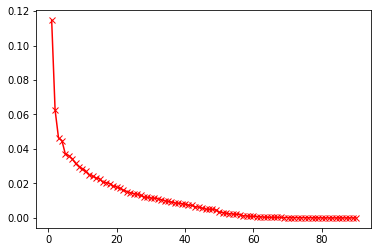

In [0]:
# Scree plot
y = pca_2.explained_variance_ratio_

x = np.array([i for i in range(1, len(y)+1)])

plt.plot(x, y, 'r-x')

In [0]:
# Filter principle components
sum(pca_2.explained_variance_ratio_[:30])


#X_pca # Training features
#new_df.IsAlert # Target features

0.8249402833159905

In [0]:
t_pca = t_pca[:,:14] # Slice the first 14 features
t_pca.shape 